In [1]:
using IJulia 
IJulia.installkernel("Julia nodeps")
IJulia.clear_output();

In [2]:
using Pkg
using DataFrames
using Plots
using Clustering
using CSV
IJulia.clear_output();

# Wczytanie danych

In [3]:
data = CSV.read("C:\\Users\\lukas\\Desktop\\clustering.txt",header = ["x","y"])
first(data,5)

,x,y
,Float64,Float64
1,41.7889,52.2202
2,-96.5865,90.957
3,-54.1436,-99.1534
4,19.9292,-45.8598
5,-82.9411,84.0992


Te dane reprezentują punkty w przestrzeni \\( \mathbb{R}^2 \\).
Policzmy podstawowe statystyki dla tego zbioru punktów.

Średnie:  \\( \bar{x} = -0.581 , \bar{y} = -8.010\\)

Minimia i Maksima:\\( x_{min} = -107.434 , y_{min} = -128.984 , x_{max} = 109.733 , y_{max} = 99.936\\)

Wiemy już gdzie znajdują się nasze punkty.

# Wizualizacja 

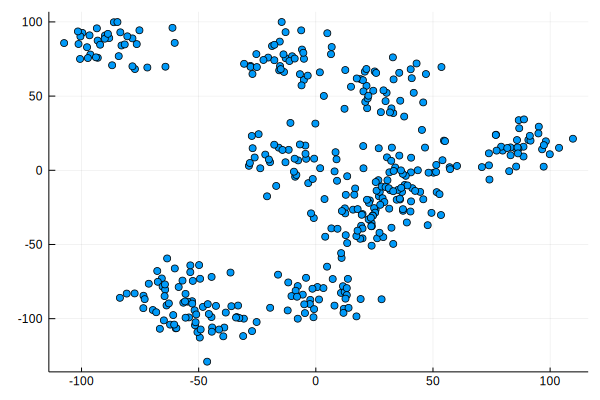

In [4]:
p = plot(data[1],data[2],seriestype = :scatter,legend = false)
IJulia.clear_output();p

Widać że nasze punkty nie są trudne do rozdzielenia i część z nich da się łatwo podzielić i przyporządkować do grup.
Część z grup lekko się ze sobą pokrywa oraz kilka punktów leży pomiędzy grupami.

# Klasteryzacja

Do tego procesu użyje pakietu [Clustering.jl](https://github.com/JuliaStats/Clustering.jl) .
Pierwszym algorytmem będzię K-means.
Zasada algorytmu polega na wylosowaniu n par współrzędnych i przyporządkowaniu każdego punktu z danych do najbliższej pary współrzędnych.
Następnie dla każdej grupy punktów przyporządkowanej do konkretnej współrzędnej wyliczana jest nowa para współrzędnych na podstawie średniej z punktów należących do konkretnej grupy punktów. Proces ten powtarzamy dopóki zachodzi zmiana przyporządkowania punktów do grup lub przkroczymy wyznaczoną ilość iteracji algorytmu.

Sprawdzimy jak dobrze działa algorytm przyporządkowując go kolejno do k =  1,2,3...\\(\left \lfloor{\sqrt{n}}\right \rfloor\\) grup. 
Do zmierzenia jak dobrze klasteryzyje ten algorytm użyjemy metryki sumy odległości punktów z każdej każdej grupy do ich punktu środkowego.
Algorytm ten inicjuje współrzędne startowe środków każdej grupy losowo.
Aby zmaniejszyć wpływ losowości każde grupowanie wyznaczymy 100 razy.

In [5]:
data_mat_T = transpose(convert(Matrix,data));
n = convert(Int16,floor(√size(data)[1]))
Costs = zeros(n)
for i=1:100
    for j=1:n
        R = kmeans(data_mat_T, j; maxiter=200)
        Costs[j] += R.totalcost
    end
end
Costs = Costs/100;

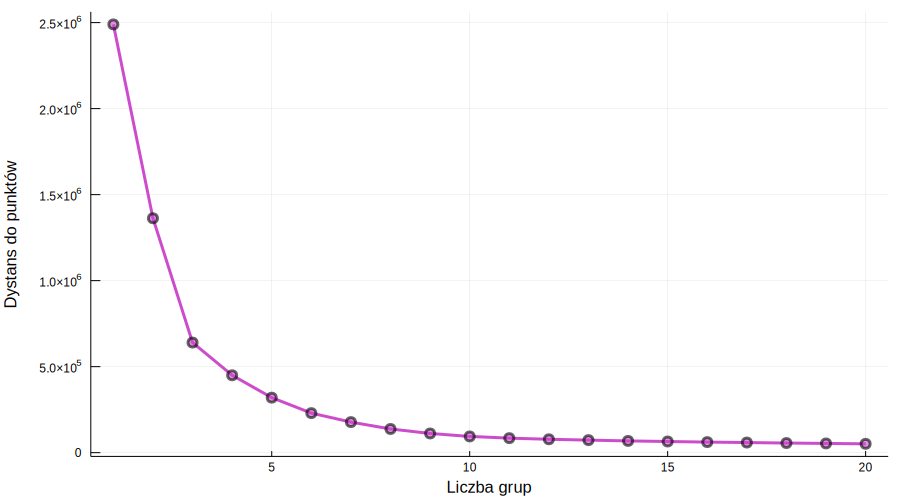

In [6]:
p1 = plot(Costs, legend= false , lw = 3, xlabel = "Liczba grup", ylabel = "Dystans do punktów",
    color=:lightrainbow, marker = (:circle, 5, 0.6, :match, stroke(3, 0.2, :black, :dot)),size = (900, 500))
IJulia.clear_output();p1

Dla wartości parametru K = 1,2,3 nasz algorytm ma bardzo złe wyniki. Dlatego skupimy się na wykresie dla k > 3.

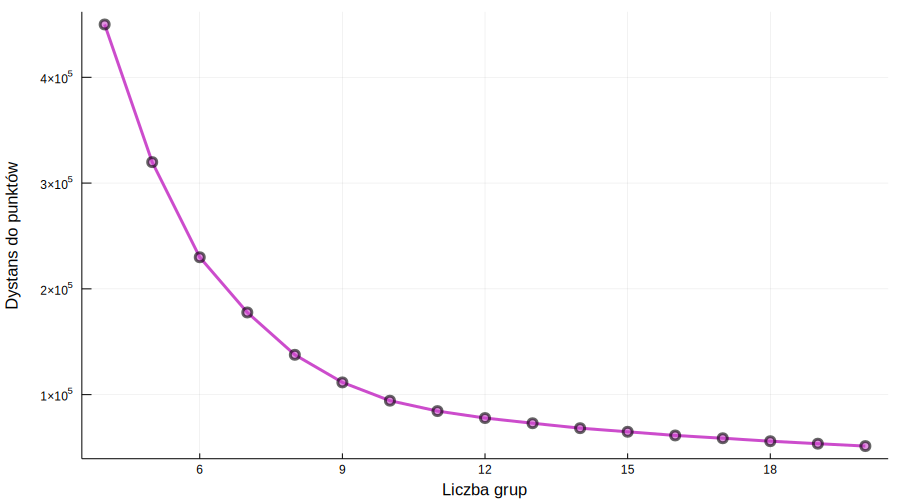

In [7]:
p2 = plot(4:n,Costs[4:n], legend= false , lw = 3, xlabel = "Liczba grup", ylabel = "Dystans do punktów",
    color=:lightrainbow, marker = (:circle, 5, 0.6, :match, stroke(3, 0.2, :black, :dot)),size = (900, 500))
IJulia.clear_output();p2  

Na powyższym wykresie widać wypłaszczenie w okolicach parametru k = 9.
Dlatego sprawdzmy teraz jak wyglądają te klasteryzacje dla parametrów 7,8,9,10.

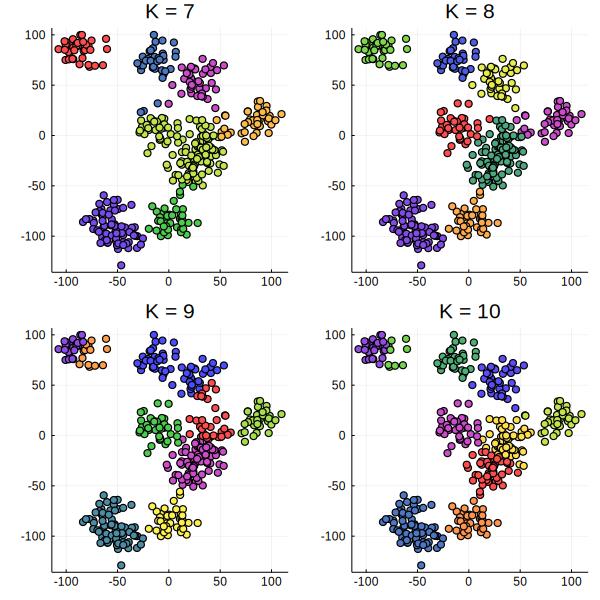

In [8]:
R7 = kmeans(data_mat_T, 7; maxiter=200);
sc7 = scatter(data[1], data[2], marker_z=R7.assignments,color=:lightrainbow, legend=false,title = "K = 7")
R8 = kmeans(data_mat_T, 8; maxiter=200);
sc8 = scatter(data[1], data[2], marker_z=R8.assignments,color=:lightrainbow, legend=false,title = "K = 8")
R9 = kmeans(data_mat_T, 9; maxiter=200);
sc9 = scatter(data[1], data[2], marker_z=R9.assignments,color=:lightrainbow, legend=false,title = "K = 9")
R10 = kmeans(data_mat_T, 10; maxiter=200);
sc10 = scatter(data[1], data[2], marker_z=R10.assignments,color=:lightrainbow, legend=false,title = "K = 10")
IJulia.clear_output();
plot(sc7, sc8, sc9, sc10, layout = (2, 2), legend = false,size = (600,600))

Trudno wykazać wyższość którejkolwiek wartości parametru k nad innymi.

# Hierarchical Clustering

Użyjemy teraz algorytmu który na początku tworzy tyle klasatrów ile mamy punktów a potem łączy ze sobą te którę są odpowiednio blisko.
Dzięki temu tworzy się drzewo które ma 400 liści po kolei łączy podobne do siebie klastry. 
Możemy więc wybierać ile klastrów chcemy oraz do jakiego stopnia podobieństwa klastry powinny być złączone.

Stowrzymy teraz macierz odległości według której będzie obliczany stopień podobieństwa.

In [22]:
Data = zeros(400,400);
for i=1:400
    for j=1:400
        Data[i,j] = √((data[i,1] - data[j,1])^2 + (data[i,2] - data[j,2])^2)
    end
end

In [36]:
result = hclust(Data, linkage=:single);

Do znajdywania klastrów przydatna jest funkcja cutree w której dzięki parametrą k,h jesteśmy w stanie wybrać kolejno:

Ilość klastrów

Stopień podobieństwa

In [40]:
cutree(result, k = 8, h = 4);

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[45]:1
└ @ Core In[45]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[45]:1
└ @ Core In[45]:1


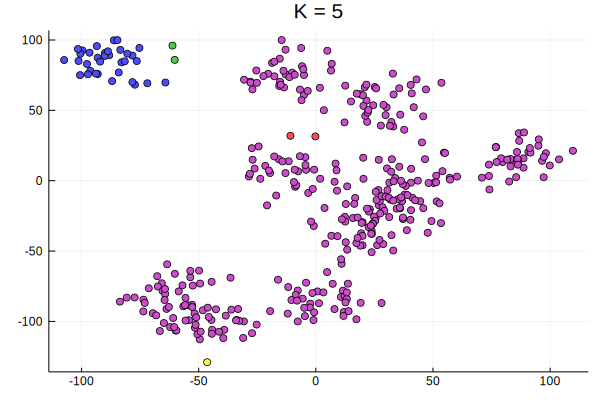

In [45]:
hiech = scatter(data[1], data[2], marker_z=cutree(result, k = 5),color=:lightrainbow, legend=false,title = "K = 5")

Jak widać otrzymujemy inny sposób klasteryzacji.
Zamiast otrzymywać klastery bisko dużych skupisk punktów dostajemy ogormne klastery jak i bardzo małe.

Z powodu małych zasobów czasowych do określenia odpowiedniej liczby klasterów użyje wieloletniego doświadczenia i użyje metody 𝜋 razy oko.

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[48]:1
└ @ Core In[48]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[48]:1
└ @ Core In[48]:1


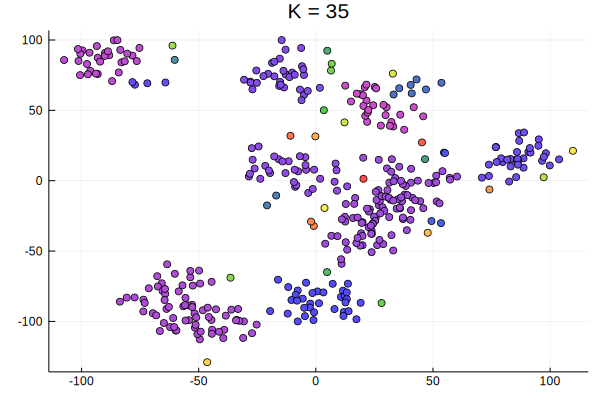

In [48]:
hiech = scatter(data[1], data[2], marker_z=cutree(result, k = 35),color=:lightrainbow, legend=false,title = "K = 35")

Dla k = 35 otrzymujemy dobre wyniki.